# 5 different ensembling strategies 


Inspired by https://www.kaggle.com/code/paharpurailab/predicting-road-accident-risk-blending. Thanks for sharing!

[I 2025-10-30 19:58:15,766] A new study created in memory with name: no-name-799d37f6-8b71-46c4-b49e-dcb03d599975
[I 2025-10-30 19:58:15,777] Trial 0 finished with value: 0.11958402844965534 and parameters: {'w0': 0.9568837599867144, 'w1': 0.2976838852950132, 'w2': 0.7576441471859697, 'w3': 0.5943573462382116}. Best is trial 0 with value: 0.11958402844965534.
[I 2025-10-30 19:58:15,780] Trial 1 finished with value: 0.32423708596534784 and parameters: {'w0': 0.1226045488976113, 'w1': 0.3328521985989368, 'w2': 0.09038236227606877, 'w3': 0.6692793289552135}. Best is trial 0 with value: 0.11958402844965534.
[I 2025-10-30 19:58:15,781] Trial 2 finished with value: 0.28116871360040385 and parameters: {'w0': 0.14689806343019518, 'w1': 0.2103332855431933, 'w2': 0.7784745058255294, 'w3': 0.31855739962826246}. Best is trial 0 with value: 0.11958402844965534.
[I 2025-10-30 19:58:15,783] Trial 3 finished with value: 0.2221680187103808 and parameters: {'w0': 0.8154832805159224, 'w1': 0.960586067374

Loaded 4 submissions with 172585 rows.


[I 2025-10-30 19:58:15,817] Trial 11 finished with value: 0.06180275478206536 and parameters: {'w0': 0.6254549580761829, 'w1': 0.6512330088655853, 'w2': 0.3565234198168762, 'w3': 0.3988844849889294}. Best is trial 11 with value: 0.06180275478206536.
[I 2025-10-30 19:58:15,825] Trial 12 finished with value: 0.08619599539972878 and parameters: {'w0': 0.6456721205856829, 'w1': 0.6451563347454876, 'w2': 0.3054306607856381, 'w3': 0.3891369852206243}. Best is trial 11 with value: 0.06180275478206536.
[I 2025-10-30 19:58:15,832] Trial 13 finished with value: 0.15322543530317173 and parameters: {'w0': 0.7177519258680574, 'w1': 0.6462375130222368, 'w2': 0.2741456518039067, 'w3': 0.26681847037228723}. Best is trial 11 with value: 0.06180275478206536.
[I 2025-10-30 19:58:15,840] Trial 14 finished with value: 0.10688703263493586 and parameters: {'w0': 0.530565557248693, 'w1': 0.741684503217944, 'w2': 0.27120708018448375, 'w3': 0.42851198759369385}. Best is trial 11 with value: 0.06180275478206536.

Weights
  Confidence prior      : [0.25 0.25 0.25 0.25]
  Corr-Conf (Strategy C): [0.315  0.1712 0.3424 0.1714]
  Optuna (Strategy D)   : [0.2482 0.2503 0.2537 0.2478]
✅ Saved final blend (ens_corrconf) -> submission.csv


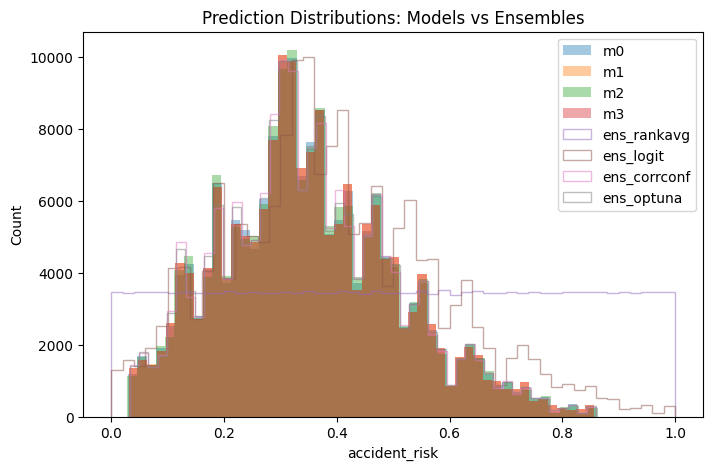

In [1]:
# ======================================================
# ⚙️ Three Ensemble Strategies + Diagnostics (Matplotlib)
# ======================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna

# ---------- 0) CONFIG ----------
# List your submission files and (optional) public RMSEs.
files = [
    '/kaggle/input/playground-5-10-top-submissions/submission aliffa agnur autogluon16.csv',
    '/kaggle/input/playground-5-10-top-submissions/submission anthonythierren cb ensemble.csv',
    '/kaggle/input/playground-5-10-top-submissions/submission sung hur.csv',
    '/kaggle/input/playground-5-10-top-submissions/submission.csv'
]
public_rmse = [0.05539, 0.05539, 0.05540, 0.05538]  # if unknown, set all equal

target_col = 'accident_risk'  # change if needed
id_col = 'id'
clip_min, clip_max = 1e-6, 1 - 1e-6  # for logit averaging
seed = 42

# ---------- 1) LOAD ----------
subs = [pd.read_csv(f) for f in files]
assert all(id_col in s.columns and target_col in s.columns for s in subs), "Missing id/target columns"
# align by id (safe guard)
base = subs[0][[id_col]].copy()
for i, s in enumerate(subs):
    base = base.merge(s[[id_col, target_col]].rename(columns={target_col: f'm{i}'}), on=id_col, how='inner')

ids = base[id_col].values
preds = base[[c for c in base.columns if c.startswith('m')]].values  # shape: (N, M)
M = preds.shape[1]
print(f"Loaded {M} submissions with {preds.shape[0]} rows.")

# ---------- 2) UTILS ----------
def minmax01(x):
    x = x.astype(float)
    mn, mx = x.min(), x.max()
    return (x - mn) / (mx - mn + 1e-12)

def safe_logit(p):
    p = np.clip(p, clip_min, clip_max)
    return np.log(p / (1 - p))

def safe_sigmoid(z):
    return 1 / (1 + np.exp(-z))

def to_ranks01(X):
    # rank each column -> [0,1]
    R = np.empty_like(X, dtype=float)
    n = X.shape[0]
    for j in range(X.shape[1]):
        order = np.argsort(X[:, j])
        ranks = np.empty(n, dtype=float)
        ranks[order] = np.arange(n)
        R[:, j] = ranks / max(n - 1, 1)
    return R

def pearson_corr_matrix(X):
    # X: (N, M)
    Xc = X - X.mean(0, keepdims=True)
    denom = np.sqrt((Xc**2).sum(0, keepdims=True))
    denom[denom == 0] = 1.0
    Z = Xc / denom
    return Z.T @ Z / (X.shape[0] - 1 + 1e-12)

# ---------- 3) STRATEGY A: Rank Averaging (robust, scale-free) ----------
ranks01 = to_ranks01(preds)
rank_avg = ranks01.mean(axis=1)  # in [0,1]
ens_rankavg = rank_avg  # leave in [0,1]; if your target needs original scale, rescale to mean scale instead

# ---------- 4) STRATEGY B: Logit (Geometric) Averaging ----------
# For non-probability outputs: min-max each model to [0,1] first, then logit-mean
norm01 = np.column_stack([minmax01(preds[:, j]) for j in range(M)])
logits = np.column_stack([safe_logit(norm01[:, j]) for j in range(M)])
logit_mean = logits.mean(axis=1)
ens_logit = safe_sigmoid(logit_mean)  # in [0,1]

# ---------- 5) STRATEGY C: Correlation-Aware Confidence Weighting ----------
# Idea: weight ∝ confidence (from public RMSE) and inversely to average correlation with others (diversity bonus)
conf = np.exp(-np.array(public_rmse, dtype=float))
conf = conf / conf.sum()

C = pearson_corr_matrix(preds)
# average correlation of model i with the others (excluding diag)
avg_corr = (C.sum(axis=1) - 1.0) / np.maximum(M - 1, 1)
diverse = 1.0 / (1e-6 + (avg_corr - avg_corr.min()) / max(avg_corr.max() - avg_corr.min(), 1e-12) + 1.0)
raw_w = conf * diverse
w_corrconf = raw_w / raw_w.sum()
ens_corrconf = preds @ w_corrconf

# ---------- 6) (Optional) STRATEGY D: Optuna fine-tuned weights (convex, prior = conf) ----------
def objective(trial):
    w = np.array([trial.suggest_float(f"w{i}", 0.0, 1.0) for i in range(M)], dtype=float)
    w /= w.sum() + 1e-12
    # Unsupervised surrogate objective:
    #  - keep weights near confidence prior (L2 to conf)
    #  - discourage using highly correlated models (w^T C w term)
    #  - mild entropy encouragement for non-collapse
    prior_term = np.sqrt(((w - conf) ** 2).sum())
    corr_term = float(w @ C @ w)  # smaller is better (less redundancy)
    entropy = -np.sum(w * np.log(w + 1e-12))
    return 1.0 * prior_term + 0.25 * corr_term - 0.05 * entropy

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=214, show_progress_bar=False)
w_opt = np.array([study.best_params[f"w{i}"] for i in range(M)], dtype=float)
w_opt = w_opt / w_opt.sum()
ens_optuna = preds @ w_opt

print("Weights")
print("  Confidence prior      :", np.round(conf, 4))
print("  Corr-Conf (Strategy C):", np.round(w_corrconf, 4))
print("  Optuna (Strategy D)   :", np.round(w_opt, 4))

# ---------- 7) PACKAGE ENSEMBLES ----------
ensembles = {
    'ens_rankavg': ens_rankavg,
    'ens_logit': ens_logit,
    'ens_corrconf': ens_corrconf,
    'ens_optuna': ens_optuna,   # optional fourth; keep or drop
}

# Choose which one to export as your final (pick based on your preference/experience).
final_choice = 'ens_corrconf'   # e.g., correlation-aware tends to be strong on LB-only settings
final = pd.DataFrame({id_col: ids, target_col: ensembles[final_choice]})
final_path = 'submission.csv'
final.to_csv(final_path, index=False)
print(f"✅ Saved final blend ({final_choice}) -> {final_path}")

# ---------- 8) DIAGNOSTIC PLOTS ----------
# Note: Kaggle output supports inline figures. We keep pure matplotlib, one chart per figure, no color settings.

# 8.1 Distribution histograms (each base model + each ensemble)
plt.figure(figsize=(8,5))
for j in range(M):
    plt.hist(preds[:, j], bins=50, alpha=0.4, label=f'm{j}')
for k, (name, vec) in enumerate(ensembles.items()):
    plt.hist(vec, bins=50, alpha=0.5, label=name, histtype='step')
plt.title('Prediction Distributions: Models vs Ensembles')
plt.xlabel(target_col)
plt.ylabel('Count')
plt.legend()